# 5. Dataprep - Começo camada _Silver_

## 5.1. Decisão: manter ou não os clientes que não possuem tanto informação de uso (logs) quanto de pagamentos (transactions)?

Justificativa Estratégica: Manutenção de Populações Heterogêneas na Base de Modelagem

Uma decisão crítica neste projeto foi a não-exclusão de usuários que não apresentam registros em uma das tabelas core (logs ou transactions) em uma determinada safra. Embora a tentação analítica seja focar no "usuário ideal" (aquele que paga e usa), a exclusão de perfis incompletos introduziria um viés de seleção severo, comprometendo a utilidade do modelo em produção.

A manutenção desses grupos fundamenta-se em três pilares:

* Captura de Extremos de Margem: Usuários com logs mas sem transações representam o maior risco operacional (custo sem receita), enquanto usuários com transações mas sem logs representam a maior margem líquida (receita sem custo). Ignorá-los resultaria em um modelo incapaz de prever os cenários de maior impacto financeiro para o negócio;
* Poder Preditivo da Mudança de Estado: O valor real de um modelo de propensão e rentabilidade não está em identificar quem paga hoje, mas em prever quem deixará de pagar ou começará a consumir excessivamente no futuro (M+1). Manter o histórico de "silêncio" (ausência de logs ou transações) permite que o modelo aprenda padrões de inatividade que precedem o churn ou a inadimplência;
* Robustez em Produção: Um modelo treinado apenas em usuários ativos falha ao encontrar usuários intermitentes no mundo real. Ao tratar a ausência de dados como uma informação em si (via flags e imputação semântica), garantimos que o modelo seja resiliente a anomalias e variações do ciclo de vida do cliente.
Portanto, em vez de filtrar a base, optamos por enriquecer o espaço de features com interações e tendências temporais, permitindo que os algoritmos de aprendizado (especialmente os baseados em árvores) segmentem essas subpopulações internamente de forma automática e otimizada.

## 5.2. Agregacoes

### 5.2.1. Agregação Preventiva de Transações por Cliente-Mês - Contexto

Embora a base histórica não apresente múltiplas transações por cliente no mesmo mês (msno, safra), a implementação de uma camada explícita de agregação é uma decisão de engenharia voltada para robustez em produção.

Em ambientes reais, eventos como _upgrades_, _downgrades_, reprocessamentos, falhas de cobrança e retentativas podem gerar múltiplas linhas transacionais para o mesmo cliente no mesmo período. Sem tratamento adequado, isso pode:

* Duplicar registros na _spine_ de modelagem;
* Gerar inconsistências em _joins_;
* Enviesar _features_ temporais;
* Quebrar _pipelines_ de inferência.

Por isso, antes do _feature engineering_, optei por consolidar as transações no nível (msno, safra), aplicando regras de agregação específicas para cada dataframe e por tipo de variável, priorizando o último estado observado para atributos categóricos e de plano, e acumulação para valores monetários.

A ideia é que, uma vez em produção, o código base sempre execute uma verificação de duplicatas. Ao perceber, sao chamadas as funções de agregação para cada tabela e variável. Caso não haja duplicatas, o processo roda normalmente.

### 5.2.2. Agregação Preventiva de Transações por Cliente-Mês - Execução

In [ ]:
df_logs_agg = agregar_logs(df_logs)

✅ LOGS: Base já está no nível (msno, safra). Nenhuma agregação necessária.


In [ ]:
df_transactions_agg = agregar_transactions(df_transactions)

✅ TRANSACTIONS: Base já está no nível (msno, safra). Nenhuma agregação necessária.


In [ ]:
df_members_agg = agregar_members(df_members)

✅ MEMBERS: Base já está no nível (msno, safra). Nenhuma agregação necessária.


## 5.3. Tratamento de nulos e outliers

### 5.3.1. Logs

Afim de tratar os outliers encontrados na tabela em questao, aplicaremos a *Winsorização*: técnica que consiste em "limitar" os valores extremos (outliers) inferiores e superiores, substituindo-os pelos valores de um determinado percentual (ex: percentis P1 e P99). Durante a analise exploratoria de dados, tomando a variavel `num_25` como exemplo, observamos que enquanto a média é de ~95 e o percentil 99,5% está em 975, o valor máximo atinge impressionantes 111.864. Essa discrepância indica uma cauda extremamente longa à direita.

Valores extremos como este podem enviesar modelos que se baseiam em médias e variâncias (como Regressão Linear, PCA ou K-means). A Winsorização mitiga esse efeito sem a perda de linhas que ocorreria em um "trimming" (remoção direta), mantendo o tamanho da amostra para o treinamento. O valor máximo de 111 mil músicas parciais em um período de log provavelmente não reflete o comportamento de um usuário humano, sendo possivelmente fruto de erros de medição, bots ou contas compartilhadas. O "capping" via Winsorização traz esses registros para um limite estatisticamente aceitável.

2. Justificativa de Negócio
* Foco no Usuário Real: Para fins de recomendação ou predição de churn, o negócio está interessado no comportamento do consumidor típico. Usuários com volumes astronômicos (outliers) distorcem os KPIs (indicadores-chave de desempenho), levando a interpretações errôneas sobre o engajamento médio da base.

* Consistência em Ambientes de Produção: Aplicar uma função padronizada de Winsorização (como a aplicar_winsorizacao definida no código) permite que o processo de limpeza de dados seja automatizado e replicável em diferentes safras de dados, garantindo que o modelo de ML não "quebre" ao encontrar novos valores extremos no futuro.

* Integridade da Base: Como cerca de 56% dos usuários aparecem apenas uma vez na base de logs, é crucial que os registros desses usuários — que já possuem pouca informação histórica — não sejam simplesmente deletados por serem outliers, mas sim ajustados para não prejudicar a performance preditiva do modelo.

In [ ]:
df_logs_fix = aplicar_winsorizacao(df_logs_agg, ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"])

Coluna num_25: Limite Inferior=0.0, Limite Superior=746.0
Coluna num_50: Limite Inferior=0.0, Limite Superior=174.0
Coluna num_75: Limite Inferior=0.0, Limite Superior=101.0
Coluna num_985: Limite Inferior=0.0, Limite Superior=122.0
Coluna num_100: Limite Inferior=0.0, Limite Superior=3487.0
Coluna num_unq: Limite Inferior=1.0, Limite Superior=2819.0
Coluna total_secs: Limite Inferior=28.11, Limite Superior=881683.002


#### Salvar base

In [ ]:
df_logs_fix.coalesce(4).write.mode("overwrite").parquet("C:\\Users\\Gustavo\\Downloads\\datamaster\\dados\\silver\\df_logs_fix.parquet")

### 5.3.2. Transactions

In [ ]:
df_transactions_fix = (df_transactions_agg
    .withColumn("payment_plan_days", F.col("payment_plan_days").cast("int"))
    .withColumn("payment_method_id", F.col("payment_method_id").cast("int"))
    .withColumn("plan_list_price", F.col("plan_list_price").cast("float"))
    .withColumn("actual_amount_paid", F.col("actual_amount_paid").cast("float"))
    .withColumn("is_auto_renew", F.col("is_auto_renew").cast("int"))
    .withColumn("transaction_date", F.to_date(F.col("transaction_date"), "yyyyMMdd"))
    .withColumn("membership_expire_date", F.to_date(F.col("membership_expire_date"), "yyyyMMdd"))
    .withColumn("is_cancel", F.col("is_cancel").cast("int"))
)

In [ ]:
df_transactions_fix.show(5, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|38               |410              |1788.0         |1788.0            |0            |2015-11-21      |2017-01-04            |0        |201511|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41               |30               |149.0          |149.0             |1            |2015-05-26      |2015-06-26            |0        |201505|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41       

#### membership_expire_date

In [ ]:
df_transactions_fix = df_transactions_fix.withColumn("flag_expire_invalido",
    F.when(F.col("membership_expire_date") < "2015-01-01", 1).otherwise(0))


In [ ]:
calcular_distribuicao(df_transactions_fix, ["flag_expire_invalido"])

+--------------------+--------+---------+
|flag_expire_invalido|total   |pct_total|
+--------------------+--------+---------+
|0                   |20705003|99.97    |
|1                   |7222    |0.03     |
+--------------------+--------+---------+



DataFrame[flag_expire_invalido: int, total: bigint, pct_total: double]

In [ ]:
df_transactions_fix.coalesce(4).write.mode("overwrite").parquet("C:\\Users\\Gustavo\\Downloads\\datamaster\\dados\\silver\\df_transactions_fix.parquet")

### 5.3.3. Members

In [ ]:
df_members_fix = (df_members_agg
    .withColumn("registration_init_time", F.to_date(F.col("registration_init_time"), "yyyyMMdd"))
    .withColumn("city", F.col("city").cast("int"))
    .withColumn("bd", F.col("bd").cast("int"))
    .withColumn("registered_via", F.col("registered_via").cast("int"))
    .withColumn("is_ativo", F.col("is_ativo").cast("int"))
)

In [ ]:
df_members_fix.show(5, truncate=False)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|2014-09-27            |1   |0  |NULL  |7             |1       |
|++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=|201607|2015-03-22            |1   |0  |NULL  |9             |0       |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201601|2012-12-17            |15  |32 |male  |3             |1       |
|++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=|201603|2013-11-12            |14  |21 |male  |7             |0       |
|++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=|201610|2014-10-21            |5   |33 |male  |3             |0       |
+--------------------------------------------+------+-----------

#### bd (idade)

A variável de idade (bd) apresenta valores inválidos e inconsistentes, como zeros e idades irreais. Esses casos devem ser tratados como informação ausente, e não como outliers estatísticos. Foi criada uma flag indicativa de idade inválida.

In [ ]:
df_members_fix = df_members_fix.withColumn("flag_idade_invalida",
    F.when(
        (F.col("bd") < 16) | # idade minima para assinatura segundo termos de uso
        (F.col("bd") > 80) | # idade maxima razoavel, mediante entendimento do desenvolvedor
        (F.col("bd").isNull()), 1)\
    .otherwise(0))

In [ ]:
calcular_distribuicao(df_members_fix, ["flag_idade_invalida"], n_show=25)

+-------------------+--------+---------+
|flag_idade_invalida|total   |pct_total|
+-------------------+--------+---------+
|1                  |39794138|62.31    |
|0                  |24073108|37.69    |
+-------------------+--------+---------+



DataFrame[flag_idade_invalida: int, total: bigint, pct_total: double]

In [ ]:
df_members_fix = df_members_fix.withColumn("idade_clean",
    F.when(F.col("flag_idade_invalida") == 1, None).otherwise(F.col("bd")))

In [ ]:
df_members_fix.select("idade_clean").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|       idade_clean|
+-------+------------------+
|  count|          24073108|
|   mean|29.733778870597018|
| stddev|10.126336376192915|
|    min|                16|
|     1%|                16|
|     5%|                17|
|    25%|                22|
|    50%|                27|
|    75%|                35|
|    95%|                50|
|  99.5%|                65|
|    max|                80|
+-------+------------------+



#### gender

In [ ]:
df_members_fix = df_members_fix.withColumn("gender_clean",
    F.when(F.col("gender").isNull(), F.lit("unknown")).otherwise(F.col("gender")))

In [ ]:
calcular_distribuicao(df_members_fix, ["gender_clean"], n_show=25)

+------------+--------+---------+
|gender_clean|total   |pct_total|
+------------+--------+---------+
|unknown     |38210177|59.83    |
|male        |13075425|20.47    |
|female      |12581644|19.7     |
+------------+--------+---------+



DataFrame[gender_clean: string, total: bigint, pct_total: double]

#### Salvar base

In [ ]:
df_members_fix.coalesce(4).write.mode("overwrite").parquet("C:\\Users\\Gustavo\\Downloads\\datamaster\\dados\\silver\\df_members_fix.parquet")

# 6. Definição da _Spine_

In [ ]:
silver_path = r"C:\Users\Gustavo\Downloads\datamaster\dados\silver"

In [ ]:
df_members_fix = spark.read.parquet(f"{silver_path}/df_members_fix.parquet")

In [ ]:
df_spine = df_members_fix.filter(F.col("is_ativo").isin(1)).select("msno", "safra").distinct()

In [ ]:
df_spine.count()

11242865

In [ ]:
df_spine.show(5, truncate=False)

+--------------------------------------------+------+
|msno                                        |safra |
+--------------------------------------------+------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|
|++Bks8kE9oclzxZM3hcWs+qzsxuoXFeIE1+7pxKBCQg=|201607|
|++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=|201611|
|++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=|201612|
|++GVWCJ/8c4RVSUmn5mrt3VFGLUfmYIGVJ/SHLWPACw=|201602|
+--------------------------------------------+------+
only showing top 5 rows



A construção da base de modelagem foi baseada em uma spine temporal explícita, definida por cliente ativo e safra, garantindo que a ausência de eventos em logs ou transações não implicasse exclusão de observações.  

Clientes ativos foram identificados a partir da base de members.

In [ ]:
df_spine.write.mode("overwrite").partitionBy("safra").parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_spine")

# 7. Construção da variável de margem líquida mensal + _target_

## 7.1. Carregando e unindo bases

In [ ]:
silver_path = r"C:\Users\Gustavo\Downloads\datamaster\dados\silver"

In [ ]:
df_spine = spark.read.parquet(f"{silver_path}/df_spine")

In [ ]:
df_members_fix = spark.read.parquet(f"{silver_path}/df_members_fix.parquet")

In [ ]:
df_logs_fix = spark.read.parquet(f"{silver_path}/df_logs_fix.parquet")

In [ ]:
df_transactions_fix = spark.read.parquet(f"{silver_path}/df_transactions_fix.parquet")

In [ ]:
df_base = (df_spine
    .join(df_members_fix.filter(F.col("is_ativo").isin(1)), on=["msno", "safra"], how="left")
    .join(df_logs_fix, on=["msno", "safra"], how="left")
    .join(df_transactions_fix, on=["msno", "safra"], how="left")
)

In [ ]:
df_base.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- flag_idade_invalida: integer (nullable = true)
 |-- idade_clean: integer (nullable = true)
 |-- gender_clean: string (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: float (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_d

## 7.2. Margem líquida mensal

In [ ]:
df_base = df_base.withColumn("margem_liquida_mensal",
    F.when((F.col("actual_amount_paid").isNull()) & (F.col("num_unq").isNull()), F.lit(-50))\
    .when(F.col("actual_amount_paid").isNull() & (F.col("num_unq").isNotNull()), (0 - (50 + (0.0051 * F.col("num_unq")) + (0.0001 * F.col("total_secs")))))\
    .when((F.col("actual_amount_paid").isNotNull()) & (F.col("num_unq").isNull()), F.col("actual_amount_paid") - 50)\
    .otherwise(F.col("actual_amount_paid") - (50 + (0.0051 * F.col("num_unq")) + (0.0001 * F.col("total_secs")))))

In [ ]:
df_base.select("margem_liquida_mensal").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+---------------------+
|summary|margem_liquida_mensal|
+-------+---------------------+
|  count|             11242865|
|   mean|     50.5382748232691|
| stddev|   101.38291623295063|
|    min|         -152.5452002|
|     1%|         -106.9493839|
|     5%|   -71.24760119999999|
|    25%|   29.820134699999997|
|    50%|           59.6337951|
|    75%|           90.9997278|
|    95%|                 99.0|
|  99.5%|    807.8365229999999|
|    max|               1950.0|
+-------+---------------------+



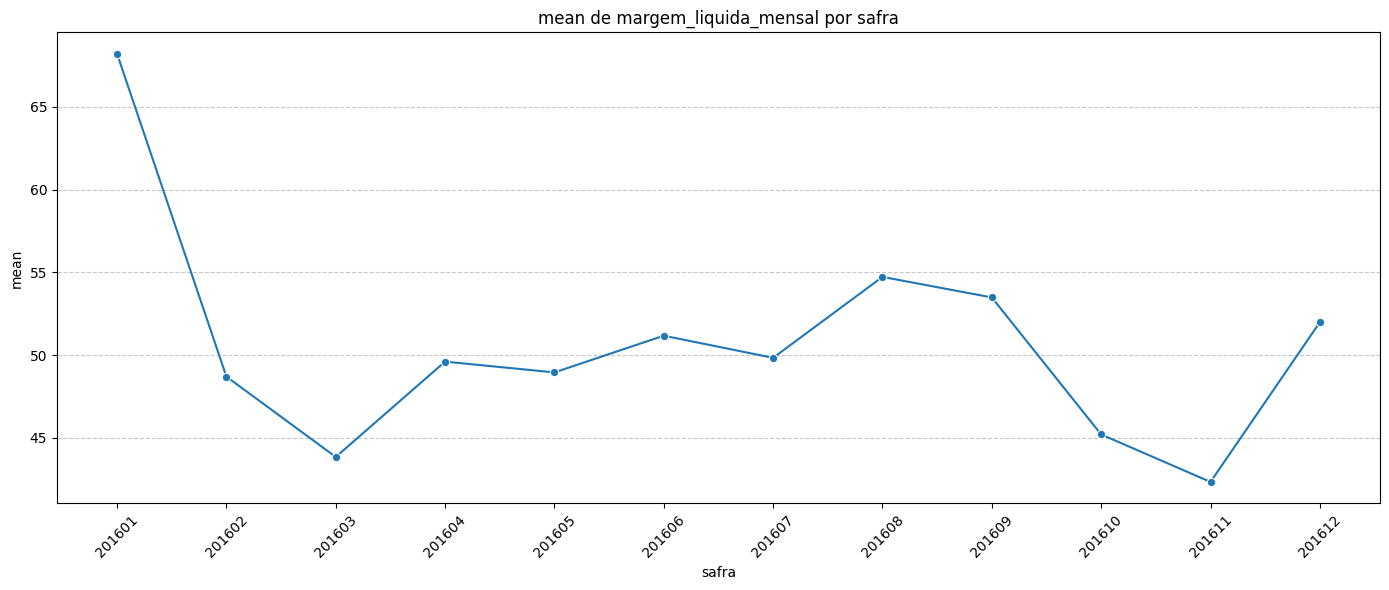

In [ ]:
plot_tendencia_temporal(df_base, col_valor="margem_liquida_mensal")

Nos melhores meses, um cliente ativo gera, em média, cerca de 50 reais de margem líquida naquele mês

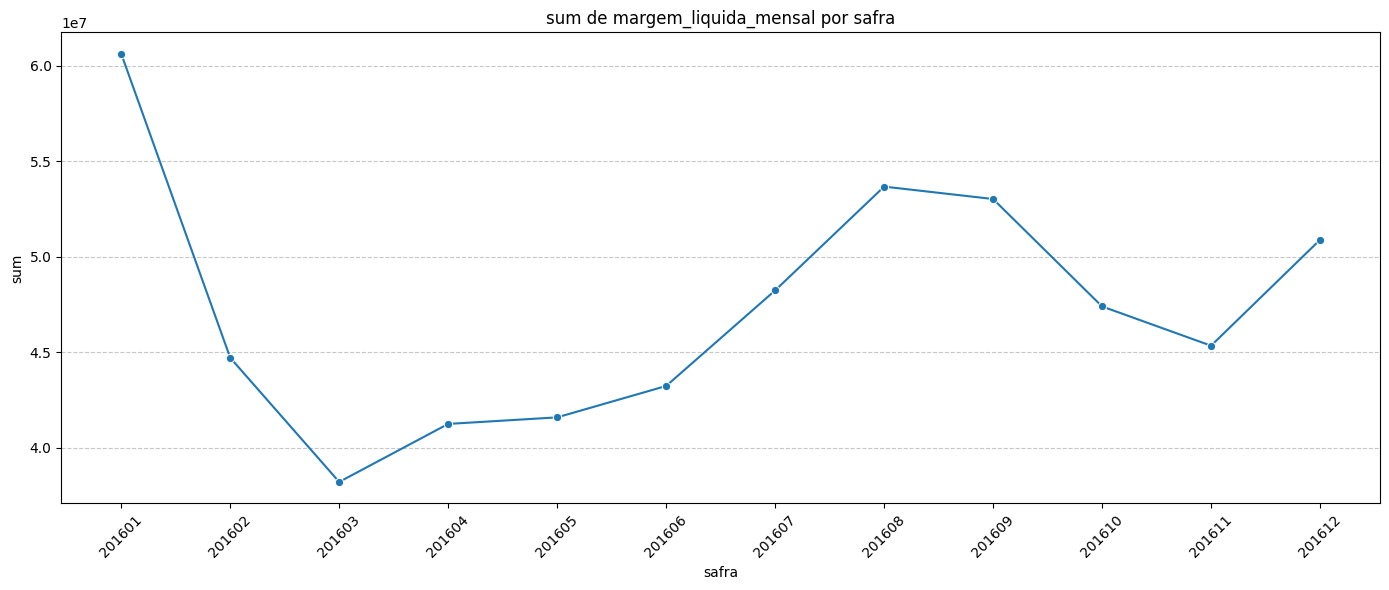

In [ ]:
plot_tendencia_temporal(df_base, col_valor="margem_liquida_mensal", aggregation="sum")

`margem_liquida_mensal` representa o resultado econômico daquele mês, sendo consequencia direta de comportamento, plano, uso e pagamento do cliente. A partir desse principio, e de que existe ao mesmo tempo que as demais variaveis, entende-se que é boa para EDA, ou seja, permite tirar insigths de sua relacao com outras variaveis. Se usarmos a target para o EDA, cairiamos em leakage, prejudicando o pipeline de modelagem, dado que as conclusoes obtidas seriam mais relacionadas a algo "suposto", mas nao concreto.

## 7.3. Target (Margem Liquida M+1)

In [ ]:
w = Window.partitionBy("msno").orderBy("safra")
# Target: margem do mês seguinte
df_base = df_base.withColumn("target", F.lead("margem_liquida_mensal", 1).over(w))

In [ ]:
df_base.select("target").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-------------------+
|summary|             target|
+-------+-------------------+
|  count|            9678866|
|   mean|  48.86269394980939|
| stddev|   81.7297910785321|
|    min|       -152.5452002|
|     1%|-108.23865709999998|
|     5%| -72.14227840000001|
|    25%| 32.626242399999995|
|    50%| 60.426585700000004|
|    75%|         90.8602606|
|    95%|               99.0|
|  99.5%|        461.2534063|
|    max|             1950.0|
+-------+-------------------+



Plotando o lucro do mês seguinte, atribuído ao mês atual (grafico diferente dos de cima pelo shift temporal):

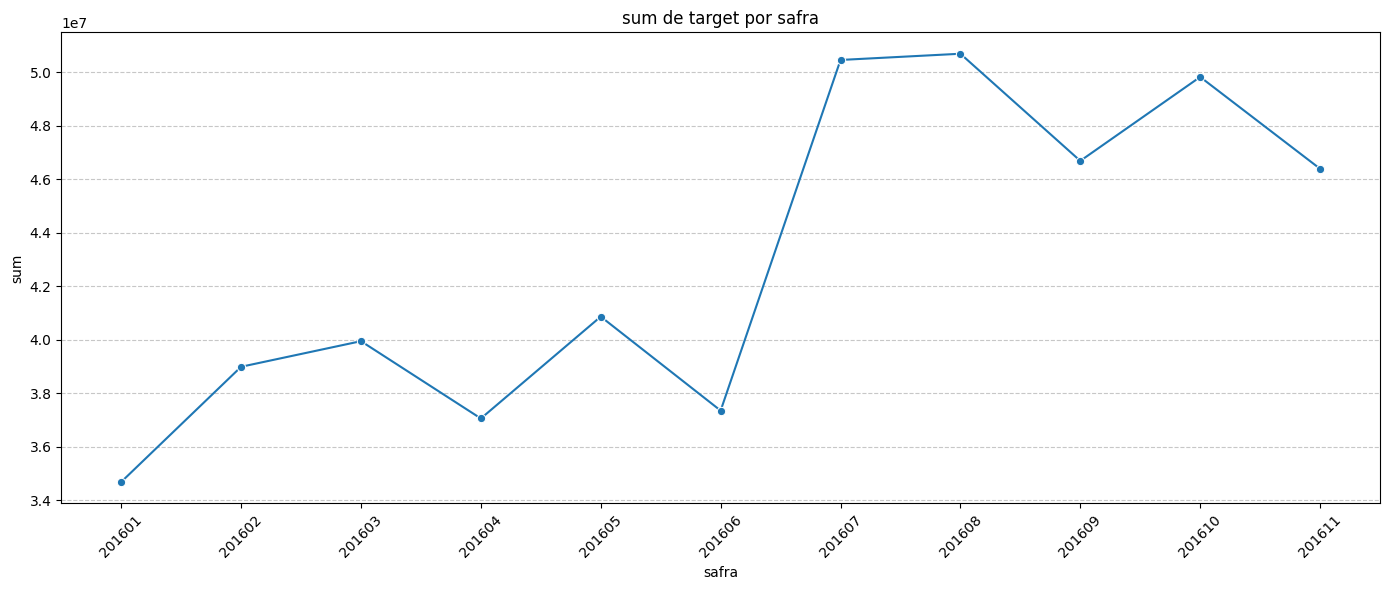

In [ ]:
plot_tendencia_temporal(df_base, col_valor="target", aggregation="sum")

### 7.3.1. Correlação da margem líquida (mês "n") com a target (margem líquida n+1) - Possibilidade para _feature engineering_

In [ ]:
# grau de correlacao de margem com target
df_base.select("target", "margem_liquida_mensal").corr("target", "margem_liquida_mensal")

0.1513006611528001

### 7.3.2. Tratamento de target - criação de target com _winsorization_

Para fins de ajuste linear (trazer maior confianca nos agrupamentos a partir da media, nao somente da mediana), vou winsorizar a target e ver o comportamento em diferentes variaveis.

In [ ]:
df_base = aplicar_winsorizacao(df_base, ["target"])

Coluna target: Limite Inferior=-108.96492529999998, Limite Superior=128.953521


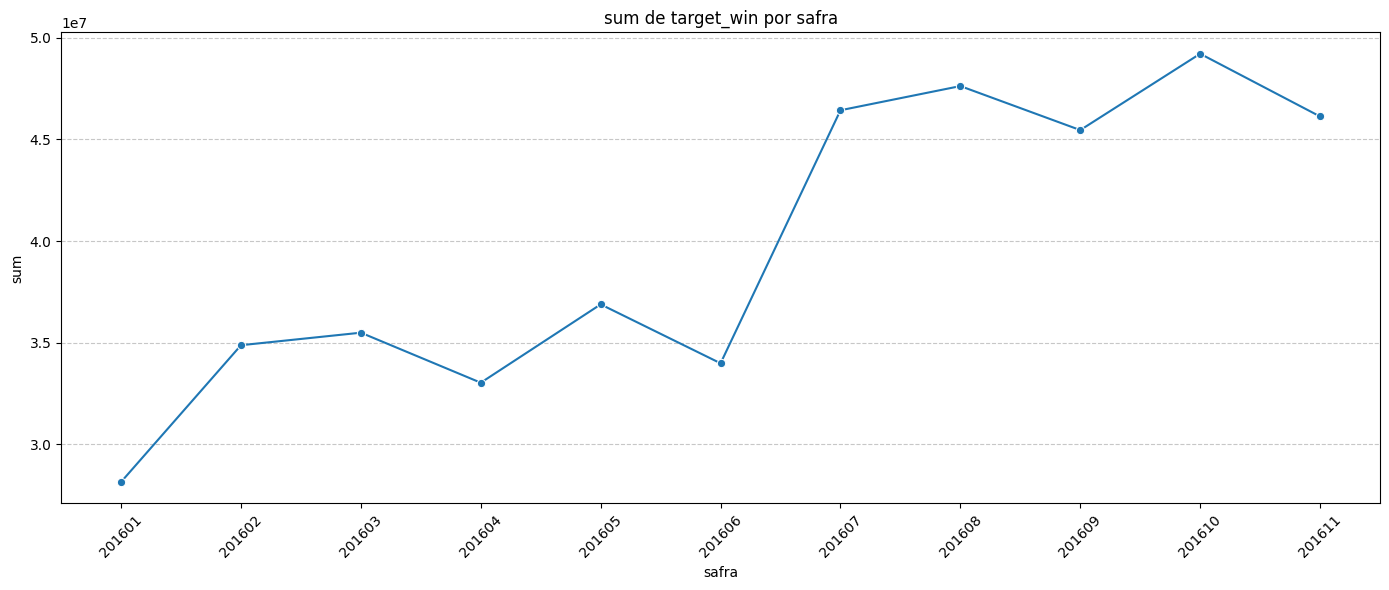

In [ ]:
plot_tendencia_temporal(df_base, col_valor="target_win", aggregation="sum")

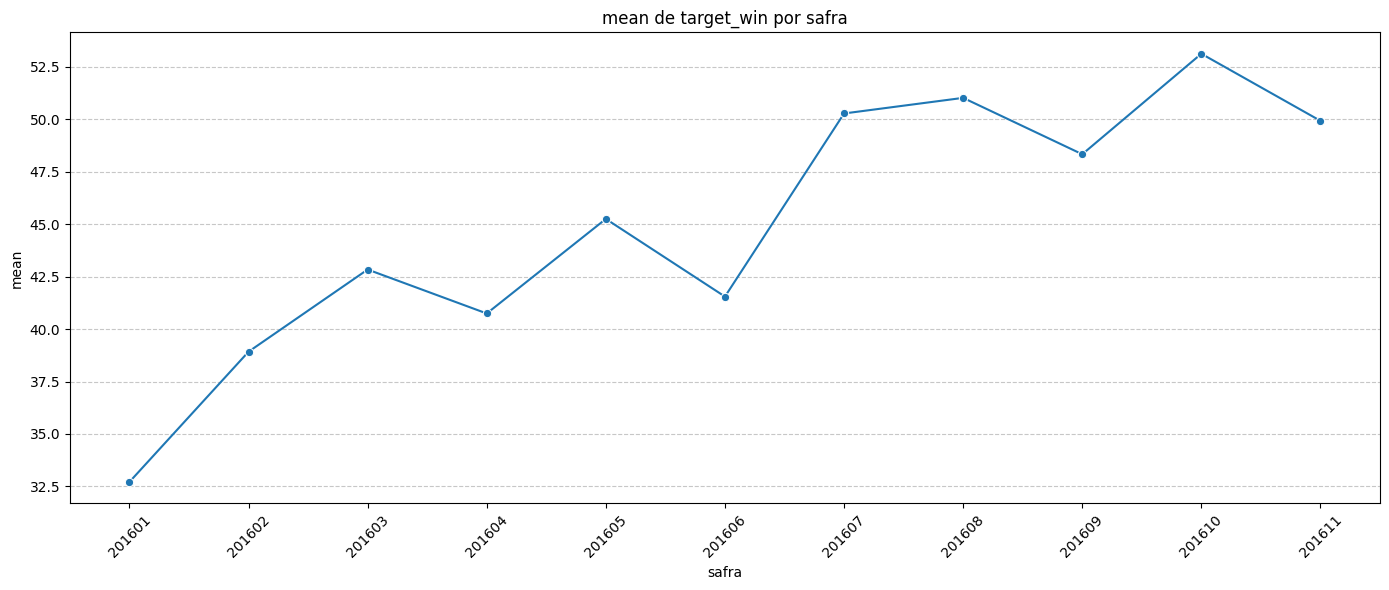

In [ ]:
plot_tendencia_temporal(df_base, col_valor="target_win", aggregation="mean")

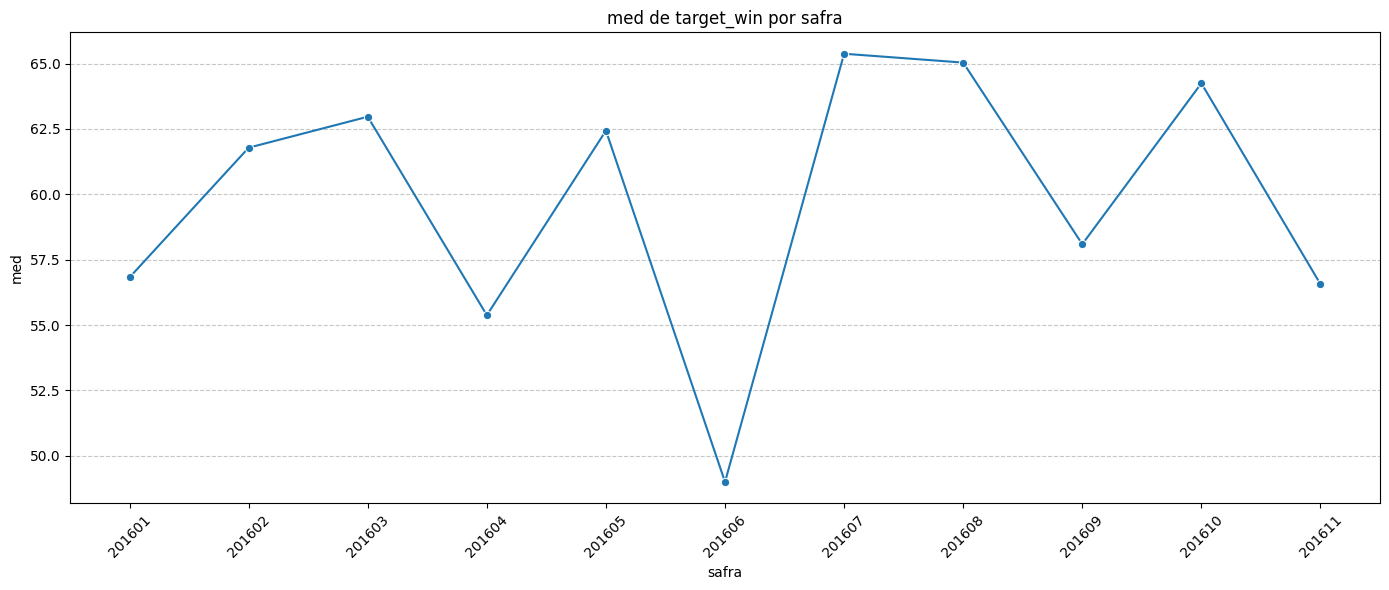

In [ ]:
plot_tendencia_temporal(df_base, col_valor="target_win", aggregation="med")